In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import os

# MyoArmband Dataset

In [5]:
train_path = 'datasets/MyoArmbandDataset/PreTrainingDataset/'
train_candidates = 12
eval_path = 'datasets/MyoArmbandDataset/EvaluationDataset/'
eval_candidates = 15

In [7]:
person_folders = os.listdir(eval_path)

keys = ['training0', 'Test0', 'Test1']

number_of_classes = 7
number_of_vector_per_example = 52
size_non_overlap = 5

raw_dataset_dict = {}
for key in keys:
        
    raw_dataset = {
        'examples': [],
        'labels': [],
    }
    list_dataset = []
    list_labels = []
    for person_dir in person_folders:
        examples = []
        labels = []
        data_path = eval_path + person_dir + '/' + key
        for data_file in os.listdir(data_path):
            if (data_file.endswith(".dat")):
                data_read_from_file = np.fromfile((data_path+'/'+data_file), dtype=np.int16)
                data_read_from_file = np.array(data_read_from_file, dtype=np.float32)

                dataset_example_formatted = []
                example = []
                emg_vector = []
                for value in data_read_from_file:
                    emg_vector.append(value)
                    if (len(emg_vector) >= 8):
                        if (example == []):
                            example = emg_vector
                        else:
                            example = np.row_stack((example, emg_vector))
                        emg_vector = []
                        if (len(example) >= number_of_vector_per_example):
                            example = example.transpose()
                            dataset_example_formatted.append(example)
                            example = example.transpose()
                            example = example[size_non_overlap:]
                dataset_example_formatted = np.array(dataset_example_formatted)
                examples.append(dataset_example_formatted)
                data_file_index = int(data_file.split('classe_')[1][:-4])
                label = data_file_index % number_of_classes + np.zeros(dataset_example_formatted.shape[0])
                labels.append(label)

        raw_dataset['examples'].append(np.concatenate(examples))
        raw_dataset['labels'].append(np.concatenate(labels))

    raw_dataset_dict[key] = raw_dataset

/var/folders/k8/_qw1v4gj2cv9cqh75_yrt3pc0000gn/T/ipykernel_31040/4057999897.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (example == []):


In [8]:
raw_dataset_dict['training0']['examples'][0].shape

(5306, 8, 52)

In [9]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomEMGDataset(Dataset):
    def __init__(self, x_samples, y_samples):
        self.x_samples = x_samples
        self.y_samples = y_samples

    def __len__(self):
        return len(self.x_samples)
    
    def __getitem__(self, idx):
        x_tensor = torch.tensor(self.x_samples[idx,:,:])
        y_tensor = torch.tensor(self.y_samples[idx]).type(torch.LongTensor)
        return x_tensor, y_tensor

In [ ]:
# single person
train_x = raw_dataset_dict['training0']['examples'][0]
train_y = raw_dataset_dict['training0']['labels'][0]
test_x = raw_dataset_dict['Test0']['examples'][0]
test_y = raw_dataset_dict['Test0']['labels'][0]

In [13]:
# all people
train_x = np.concatenate(raw_dataset_dict['training0']['examples'])
train_y = np.concatenate(raw_dataset_dict['training0']['labels'])
test_x = np.concatenate(raw_dataset_dict['Test0']['examples'])
test_y = np.concatenate(raw_dataset_dict['Test0']['labels'])

In [14]:
train_dataset = CustomEMGDataset(train_x, train_y)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomEMGDataset(train_x, train_y)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [15]:
x, y = next(iter(test_dataloader))

<AxesSubplot:>

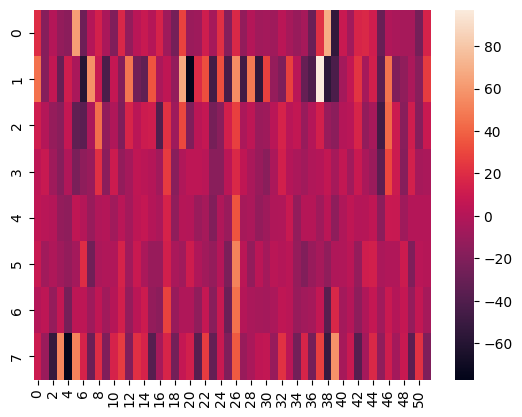

In [16]:
sns.heatmap(x[0,:,:])

In [17]:
import torch
import torch.nn as nn

In [101]:
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.flatten = nn.Flatten(start_dim=1)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        out = self.linear_relu_stack(x)
        return out

In [102]:
train_features, train_labels = next(iter(train_dataloader))

In [144]:
model = FFNN(52*8, 128, number_of_classes)

In [145]:
model(train_features).shape

torch.Size([32, 7])

In [18]:
import torch
from vit_pytorch import ViT

model = ViT(
    image_size = 52,
    patch_size = 4,
    num_classes = 7,
    dim = 64,
    depth = 1,
    heads = 2,
    mlp_dim = 128,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels=1,
)

img = torch.randn(10, 1, 8, 52)

preds = model(img)

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <59ED1CF5-3CD8-3592-A70B-3AB98E4C5F21> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [19]:
model.__class__.__name__

'ViT'

In [20]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [21]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if model.__class__.__name__ == 'ViT':
            inputs.unsqueeze_(axis=1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.8f}')
            running_loss = 0.0

    accs = []
    for data in test_dataloader:
        inputs, labels = data
        if model.__class__.__name__ == 'ViT':
            inputs.unsqueeze_(axis=1)
        model.eval()
        with torch.no_grad():
            outputs = model(inputs)
            predicted_labels = outputs.max(dim=1).indices

        acc = accuracy_score(labels, predicted_labels)
        accs.append(acc)

    print('test accuracy', np.mean(accs))

print('Finished Training')

[1,   100] loss: 1.92876304
[1,   200] loss: 1.73230485
[1,   300] loss: 1.60721234
[1,   400] loss: 1.56392165
[1,   500] loss: 1.48821062
[1,   600] loss: 1.42310641
[1,   700] loss: 1.41488457
[1,   800] loss: 1.36426049
[1,   900] loss: 1.36531197
[1,  1000] loss: 1.35037308
[1,  1100] loss: 1.34844885
[1,  1200] loss: 1.31014080
[1,  1300] loss: 1.31217722
[1,  1400] loss: 1.29279832
[1,  1500] loss: 1.29502750
[1,  1600] loss: 1.30136244
[1,  1700] loss: 1.29493697
[1,  1800] loss: 1.27477097
[1,  1900] loss: 1.25018238
[1,  2000] loss: 1.25360665
[1,  2100] loss: 1.22789168
[1,  2200] loss: 1.27182587
[1,  2300] loss: 1.22589642
[1,  2400] loss: 1.24131900
[1,  2500] loss: 1.22445934
[1,  2600] loss: 1.19964811
[1,  2700] loss: 1.21086208
[1,  2800] loss: 1.21030939
[1,  2900] loss: 1.21675210
test accuracy 0.5995556063454457
[2,   100] loss: 1.19717006
[2,   200] loss: 1.21257733
[2,   300] loss: 1.18270198
[2,   400] loss: 1.16944089
[2,   500] loss: 1.17104893
[2,   600] loss